In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy.stats import chi2
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut
from sklearn.base import clone
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from collections import Counter
from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.interpolate import interp1d
from sklearn.utils import resample
import math
from scipy.stats import wilcoxon

## Load and explore the Metatranscriptomics Data

In [3]:
#Read the file 
meta_trans = pd.read_csv("Metatranscriptomics (KEGG).csv")

In [4]:
meta_trans.shape

(60, 7073)

In [5]:
meta_trans.head()

,Sample_ID,Patient,Timepoint,K00001: alcohol dehydrogenase [EC:1.1.1.1],K00002: alcohol dehydrogenase (NADP+) [EC:1.1.1.2],K00003: homoserine dehydrogenase [EC:1.1.1.3],"K00004: (R,R)-butanediol dehydrogenase / meso-butanediol dehydrogenase / diacetyl reductase [EC:1.1.1.4 1.1.1.- 1.1.1.303]",K00005: glycerol dehydrogenase [EC:1.1.1.6],K00006: glycerol-3-phosphate dehydrogenase (NAD+) [EC:1.1.1.8],K00008: L-iditol 2-dehydrogenase [EC:1.1.1.14],...,K22988: NO_NAME,K22989: NO_NAME,K22990: NO_NAME,K22991: NO_NAME,K23001: NO_NAME,K23003: NO_NAME,K23004: NO_NAME,K23007: NO_NAME,K23015: NO_NAME,K23016: NO_NAME
0,1A,1,Baseline,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2A,2,Baseline,0.0,0.000000,0.0,0.0,2.798770,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3A,3,Baseline,0.0,0.000000,0.0,0.0,0.996578,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4A,4,Baseline,0.0,0.488329,0.0,0.0,6.075270,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5A,5,Baseline,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# intersected KO names
search_terms = ['K06726', 'K18922']

# Find columns that contain any of the terms in their names
matching_cols = [col for col in meta_trans.columns if any(term in col for term in search_terms)]

print(matching_cols)


['K06726: D-ribose pyranase [EC:5.4.99.62]', 'K18922: NO_NAME']


In [12]:
# union KO names
search_terms_u = ['K00613', 'K04764', 'K03547', 'K03832', 'K01284',
                  'K03561', 'K00626', 'K07773', 'K03605', 'K00240',
                  'K00705', 'K01808', 'K02160', 'K18921', 'K09794',
                  'K01186', 'K03286', 'K00074', 'K06186', 'K03528',
                  'K07000', 'K06973', 'K07473', 'K06078', 'K00179',
                  'K00826', 'K03746', 'K06144', 'K09475', 'K02956', 'K05540', 'K03614', 'K03154', 'K03303', 'K00175',
                  'K02439', 'K02964', 'K03642', 'K02226', 'K03324', 'K02518', 'K00346', 'K09131', 'K03812', 'K00174',
                  'K03607', 'K00349', 'K07792', 'K18862', 'K01710', 'K01809', 'K01006', 'K05803', 'K02686', 'K03732',
                  'K18922', 'K07574', 'K04064', 'K06726', 'K01007', 'K02968', 'K00040', 'K03152', 'K09458', 'K02960',
                  'K09014', 'K06204', 'K00721', 'K05839', 'K03800', 'K02858', 'K03704', 'K01719', 'K00286', 'K01823',
                  'K02761', 'K02078', 'K17319', 'K00351', 'K02429', 'K11065', 'K03557']

# Find columns that contain any of the terms in their names
matching_cols_u = [col for col in meta_trans.columns if any(term in col for term in search_terms_u)]

print(matching_cols_u)

['K00040: fructuronate reductase [EC:1.1.1.57]', 'K00074: 3-hydroxybutyryl-CoA dehydrogenase [EC:1.1.1.157]', 'K00174: 2-oxoglutarate/2-oxoacid ferredoxin oxidoreductase subunit alpha [EC:1.2.7.3 1.2.7.11]', 'K00175: 2-oxoglutarate/2-oxoacid ferredoxin oxidoreductase subunit beta [EC:1.2.7.3 1.2.7.11]', 'K00179: indolepyruvate ferredoxin oxidoreductase, alpha subunit', 'K00240: succinate dehydrogenase / fumarate reductase, iron-sulfur subunit [EC:1.3.5.1 1.3.5.4]', 'K00286: pyrroline-5-carboxylate reductase [EC:1.5.1.2]', 'K00346: Na+-transporting NADH:ubiquinone oxidoreductase subunit A', 'K00349: Na+-transporting NADH:ubiquinone oxidoreductase subunit D', 'K00351: Na+-transporting NADH:ubiquinone oxidoreductase subunit F', 'K00613: glycine amidinotransferase [EC:2.1.4.1]', 'K00626: acetyl-CoA C-acetyltransferase [EC:2.3.1.9]', 'K00705: 4-alpha-glucanotransferase [EC:2.4.1.25]', 'K00721: dolichol-phosphate mannosyltransferase [EC:2.4.1.83]', 'K00826: branched-chain amino acid aminotra

In [13]:
#Rename the coloumns name to keep only the KO IDs in Columns name

meta_trans.columns = [col.split(":")[0] for col in meta_trans.columns]

In [16]:
#Remove missing values 
meta_trans = meta_trans.dropna()

In [18]:
#Remove low expressed genes 

meta_trans = meta_trans.loc[:, (meta_trans == 0).mean(axis=0) < 0.8]

In [20]:
meta_trans.shape

(58, 2548)

In [22]:
#Filter Data according to timepoints

# Filter only Baseline and Week 4 samples
filtered_b2 = meta_trans[meta_trans['Timepoint'].isin(['Baseline', 'Week 2'])]
filtered_b4 = meta_trans[meta_trans['Timepoint'].isin(['Baseline', 'Week 4'])]
filtered_b8 = meta_trans[meta_trans['Timepoint'].isin(['Baseline', 'Week 8'])]
# Display the result
filtered_b4.head(30)


,Sample_ID,Patient,Timepoint,K00003,K00005,K00009,K00010,K00012,K00013,K00014,...,K22293,K22373,K22431,K22432,K22454,K22456,K22719,K22720,K22900,K22927
0,1A,1,Baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2A,2,Baseline,0.000000,2.798770,0.000000,0.000000,23.941400,0.000000,33.814800,...,0.000000,1.27729,3.23046,5.282250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3A,3,Baseline,0.000000,0.996578,0.000000,0.000000,18.730700,3.735150,107.213000,...,0.790109,37.65820,2.23452,2.562870,0.440444,2.029500,0.000000,2.601520,0.000000,2.817310
3,4A,4,Baseline,0.000000,6.075270,0.000000,0.000000,1.226320,0.000000,5.685480,...,0.000000,3.79893,0.00000,0.000000,2.991020,4.896100,0.000000,0.000000,0.000000,0.000000
4,5A,5,Baseline,0.000000,0.000000,0.000000,0.000000,14.500800,0.000000,45.093100,...,0.000000,29.50640,0.00000,2.656070,2.686890,5.138600,0.000000,0.000000,0.000000,0.000000
5,6A,6,Baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,7A,7,Baseline,0.000000,1.576310,0.000000,1.037020,3.177790,2.784120,12.339200,...,1.459040,10.06420,0.00000,0.000000,0.398780,0.316875,0.000000,0.104939,0.000000,9.740470
7,8A,8,Baseline,0.000000,6.266730,0.000000,0.000000,7.344350,3.411310,8.530430,...,0.000000,23.16370,3.57893,5.061650,0.000000,1.204240,0.000000,12.193000,0.000000,0.000000
8,9A,9,Baseline,0.000000,22.642200,0.000000,0.000000,0.000000,3.595150,3.167670,...,2.403180,156.41600,0.00000,1.469390,0.000000,0.477195,0.000000,0.000000,1.795960,11.685000
9,10A,10,Baseline,0.000000,0.000000,0.000000,0.000000,4.957760,0.000000,10.983100,...,0.000000,3.12761,0.00000,0.564947,0.000000,0.244412,0.000000,0.000000,0.000000,0.000000


In [24]:
# Seperate meta data from metatranscriptomic

#baseline vs week 2
y_2 = filtered_b2["Timepoint"]
x_2 = filtered_b2.drop(columns= ["Patient", "Timepoint", "Sample_ID"])

#baseline vs week 4 
y_4 = filtered_b4["Timepoint"]
x_4 = filtered_b4.drop(columns= ["Patient", "Timepoint", "Sample_ID"])

#baseline vs week 8

y_8 = filtered_b8["Timepoint"]
x_8 = filtered_b8.drop(columns= ["Patient", "Timepoint", "Sample_ID"])

#all 

y = meta_trans['Timepoint']
x = meta_trans.drop(columns= ["Patient", "Timepoint", "Sample_ID"])

In [26]:
# Log transform the xs

log_X2 = np.log1p(x_2)
log_X4 = np.log1p(x_4)
log_X8 = np.log1p(x_8)
log_X = np.log1p(x)

## PCA Baselinve vs. Week 2 

In [29]:
#perfome PCA on logged data 

pca = PCA(n_components = 2)
pca_result2 = pca.fit_transform(log_X2)

In [31]:
# Helper function to draw ellipse
def draw_ellipse(position, covariance, ax, **kwargs):
    if covariance.shape == (2, 2):
        U, s, _ = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        scale_factor = np.sqrt(chi2.ppf(0.95, df=2))  # ~2.4477
        width, height = 2 * scale_factor * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    ellipse = Ellipse(xy=position, width = width, height = height, angle = angle, **kwargs)
    ax.add_patch(ellipse)

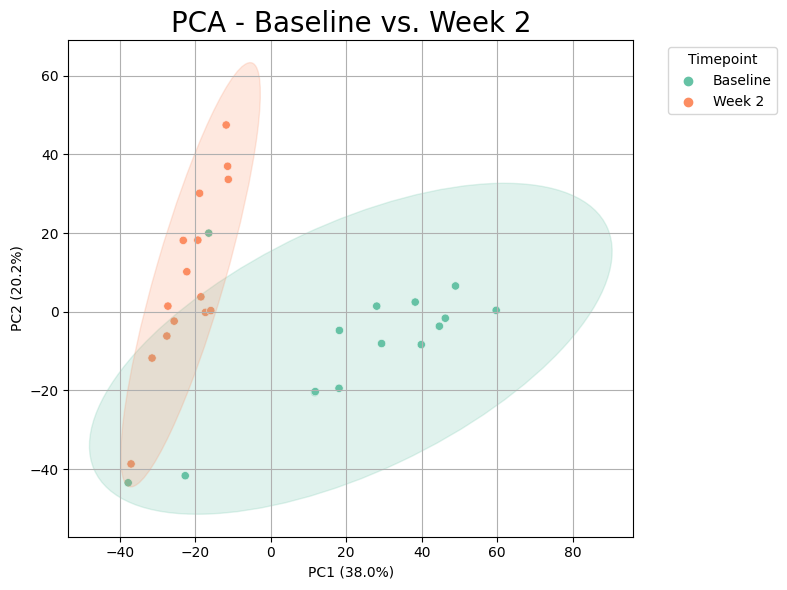

In [33]:
#Plot PCA with ellipses covering 95% CI

# Step 1: Create PCA result DataFrame
pca_df_2 = pd.DataFrame(pca_result2[:, :2], columns=['PC1', 'PC2'], index=filtered_b2.index)

# Step 2: Add Timepoint metadata
pca_df_2['Timepoint'] = y_2

# Step 3: Plot PCA with ellipses
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Scatterplot
sns.scatterplot(data=pca_df_2, x='PC1', y='PC2', hue=y_2, palette='Set2', ax=ax)

# Add ellipses for each Timepoint group
for i, timepoint in enumerate(pca_df_2['Timepoint'].unique()):
    group = pca_df_2[pca_df_2['Timepoint'] == timepoint]
    if len(group) > 2:
        cov = np.cov(group[['PC1', 'PC2']].T)
        mean = group[['PC1', 'PC2']].mean().values
        draw_ellipse(mean, cov, ax, alpha=0.2, color=sns.color_palette('Set2')[i])

# Labels and formatting
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title("PCA - Baseline vs. Week 2", fontsize = 20)
plt.legend(title='Timepoint', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig('Meta_PCA_2.png')
plt.show()

## Baseline Vs Week 4 

In [36]:
#perfome PCA on logged data 

#pca = PCA(n_components = 2)
pca_result4 = pca.fit_transform(log_X4)

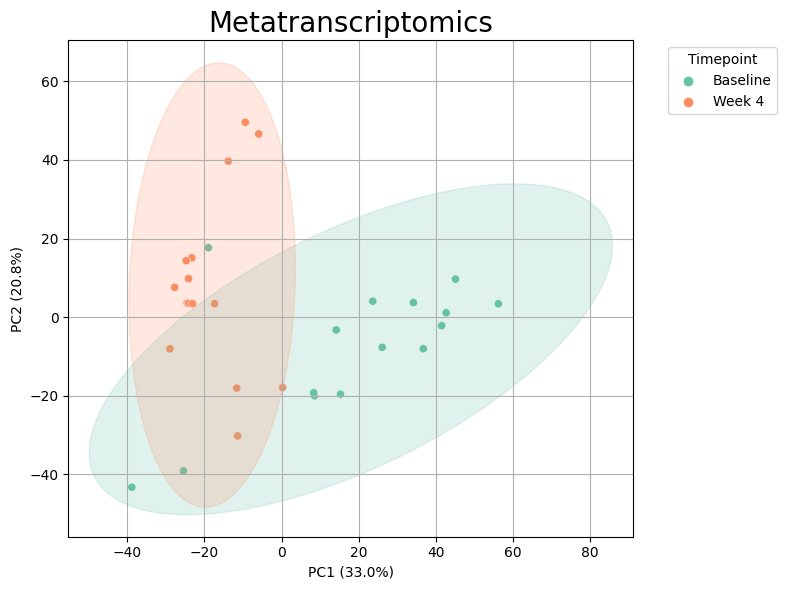

In [38]:
#Plot PCA with ellipses covering 95% CI

# Step 1: Create PCA result DataFrame
pca_df_4 = pd.DataFrame(pca_result4[:, :2], columns=['PC1', 'PC2'], index=filtered_b4.index)

# Step 2: Add Timepoint metadata
pca_df_4['Timepoint'] = y_4

# Step 3: Plot PCA with ellipses
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Scatterplot
sns.scatterplot(data=pca_df_4, x='PC1', y='PC2', hue=y_4, palette='Set2', ax=ax)

# Add ellipses for each Timepoint group
for i, timepoint in enumerate(pca_df_4['Timepoint'].unique()):
    group = pca_df_4[pca_df_4['Timepoint'] == timepoint]
    if len(group) > 2:
        cov = np.cov(group[['PC1', 'PC2']].T)
        mean = group[['PC1', 'PC2']].mean().values
        draw_ellipse(mean, cov, ax, alpha=0.2, color=sns.color_palette('Set2')[i])

# Labels and formatting
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title("Metatranscriptomics", fontsize = 20)
plt.legend(title='Timepoint', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig('Meta_PCA_4.png')
plt.show()

## Baseline Vs Week 8

In [41]:
# Perform PCA baseline vs week 8 

pca_result8 = pca.fit_transform(log_X8)

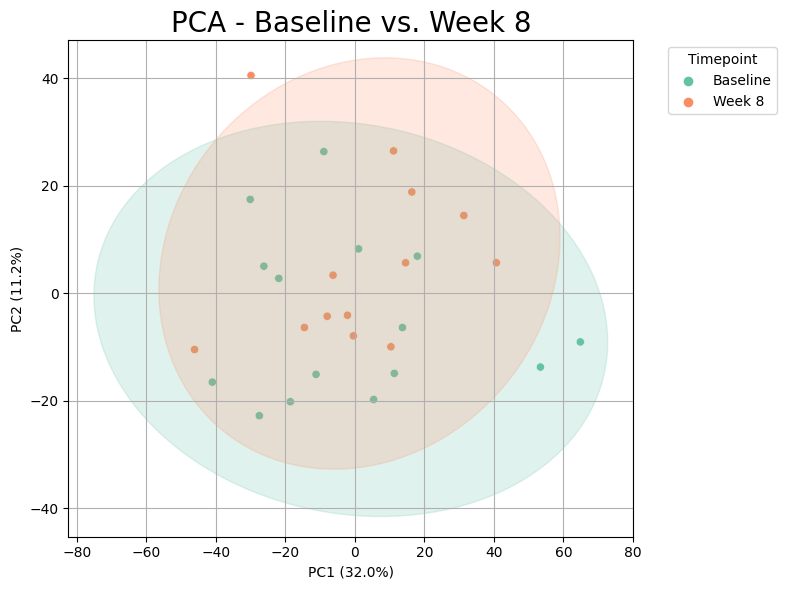

In [43]:
#Plot PCA with ellipses covering 95% CI

# Step 1: Create PCA result DataFrame
pca_df_8 = pd.DataFrame(pca_result8[:, :2], columns=['PC1', 'PC2'], index=filtered_b8.index)

# Step 2: Add Timepoint metadata
pca_df_8['Timepoint'] = y_8

# Step 3: Plot PCA with ellipses
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Scatterplot
sns.scatterplot(data=pca_df_8, x='PC1', y='PC2', hue=y_8, palette='Set2', ax=ax)

# Add ellipses for each Timepoint group
for i, timepoint in enumerate(pca_df_8['Timepoint'].unique()):
    group = pca_df_8[pca_df_8['Timepoint'] == timepoint]
    if len(group) > 2:
        cov = np.cov(group[['PC1', 'PC2']].T)
        mean = group[['PC1', 'PC2']].mean().values
        draw_ellipse(mean, cov, ax, alpha=0.2, color=sns.color_palette('Set2')[i])

# Labels and formatting
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title("PCA - Baseline vs. Week 8", fontsize = 20)
plt.legend(title='Timepoint', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig('Meta_PCA_8.png')
plt.show()

## All timepoints 

In [46]:
# Perform PCA baseline vs week 8 

pca_result_all = pca.fit_transform(log_X)

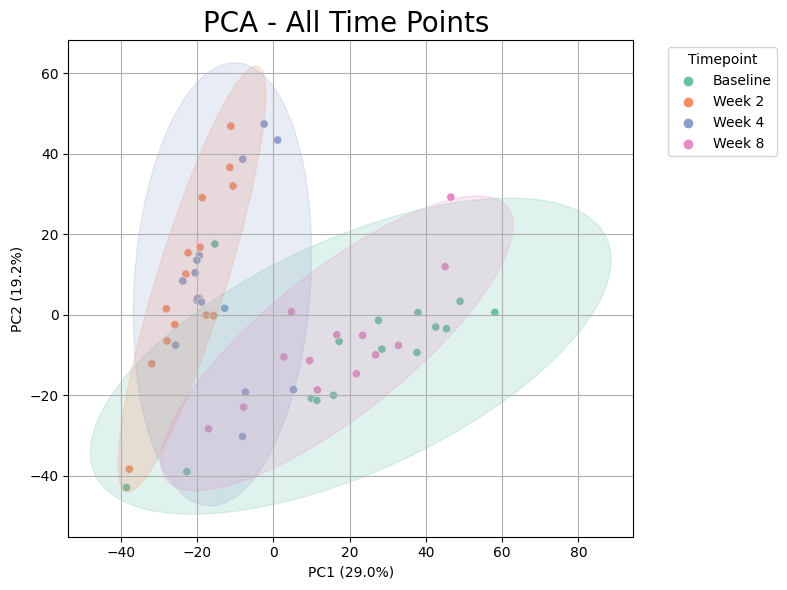

In [48]:
#Plot PCA with ellipses covering 95% CI

# Step 1: Create PCA result DataFrame
pca_df_all = pd.DataFrame(pca_result_all[:, :2], columns=['PC1', 'PC2'], index=meta_trans.index)

# Step 2: Add Timepoint metadata
pca_df_all['Timepoint'] = meta_trans['Timepoint']

# Step 3: Plot PCA with ellipses
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Scatterplot
sns.scatterplot(data=pca_df_all, x='PC1', y='PC2', hue=y, palette='Set2', ax=ax)

# Add ellipses for each Timepoint group
for i, timepoint in enumerate(pca_df_all['Timepoint'].unique()):
    group = pca_df_all[pca_df_all['Timepoint'] == timepoint]
    if len(group) > 2:
        cov = np.cov(group[['PC1', 'PC2']].T)
        mean = group[['PC1', 'PC2']].mean().values
        draw_ellipse(mean, cov, ax, alpha=0.2, color=sns.color_palette('Set2')[i])

# Labels and formatting
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title("PCA - All Time Points ", fontsize = 20)
plt.legend(title='Timepoint', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig('Meta_PCA_all.png')
plt.show()

## LASSO WITH LPOCV

In [51]:
# map y to 0 baseline and 1 to week 4 

y_4 = y_4.map({'Baseline': 0, 'Week 4': 1})

In [53]:
n_patients = 15
y_true_LA = []
y_pred_prob_LA = []
selected_genes_list_LA = []

for i in range(n_patients):
    # Leave out both time points for the same patient
    test_idx = [i, i + n_patients]
    train_idx = [j for j in range(2 * n_patients) if j not in test_idx]
   
    # Split
    X_train, X_test = log_X4.iloc[train_idx], log_X4.iloc[test_idx]
    y_train, y_test = y_4.iloc[train_idx], y_4.iloc[test_idx]

    # Inner loop for lambda selection (Elastic Net)
    inner_model_LA = LogisticRegressionCV(
        Cs=10,                      # Number of inverse lambdas to try
        cv=5,
        penalty='elasticnet',
        solver='saga',
        l1_ratios=[1.0],            
        scoring='accuracy',
        max_iter=10000,
        n_jobs=-1
    )

    pipeline_LA = make_pipeline(StandardScaler(), inner_model_LA)
    pipeline_LA.fit(X_train, y_train)


        # Get best parameters
    best_C_LA = inner_model_LA.C_[0]
    best_l1_ratio_LA = inner_model_LA.l1_ratio_[0]

    # Retrain final LA model on full training fold with best parameters
    final_model_LA = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty='elasticnet',
            C=best_C_LA,
            l1_ratio=best_l1_ratio_LA,
            solver='saga',
            max_iter=10000
        )
    )
    final_model_LA.fit(X_train, y_train)

    # Predict on left-out sample
    y_prob_LA = final_model_LA.predict_proba(X_test)[:, 1]
    y_pred_prob_LA.extend(y_prob_LA)
    y_true_LA.extend(y_test.tolist())

    # Get selected features
    coefs_LA = final_model_LA.named_steps['logisticregression'].coef_.flatten()
    selected_genes_LA = log_X4.columns[coefs_LA != 0]
    selected_genes_list_LA.append(selected_genes_LA.tolist())

In [54]:
# Evaluating LASSO model 
y_pred_label_LA = [1 if prob >= 0.5 else 0 for prob in y_pred_prob_LA]

# Accuracy
acc_LA = accuracy_score(y_true_LA, y_pred_label_LA)

# Sensitivity = Recall for class 1
sensitivity_LA = recall_score(y_true_LA, y_pred_label_LA, pos_label=1)

# Specificity = Recall for class 0
specificity_LA = recall_score(y_true_LA, y_pred_label_LA, pos_label=0)

# F1 Score
f1_LA = f1_score(y_true_LA, y_pred_label_LA)

# AUC
auc_LA = roc_auc_score(y_true_LA, y_pred_prob_LA)

# Confusion matrix
cm_LA = confusion_matrix(y_true_LA, y_pred_label_LA)

# Print metrics
print(f"Accuracy:    {acc_LA:.3f}")
print(f"Sensitivity: {sensitivity_LA:.3f}")
print(f"Specificity: {specificity_LA:.3f}")
print(f"F1 Score:    {f1_LA:.3f}")
print(f"AUC:         {auc_LA:.3f}")
print("Confusion Matrix:\n", cm_LA)

Accuracy:    0.833
Sensitivity: 0.800
Specificity: 0.867
F1 Score:    0.828
AUC:         0.902
Confusion Matrix:
 [[13  2]
 [ 3 12]]


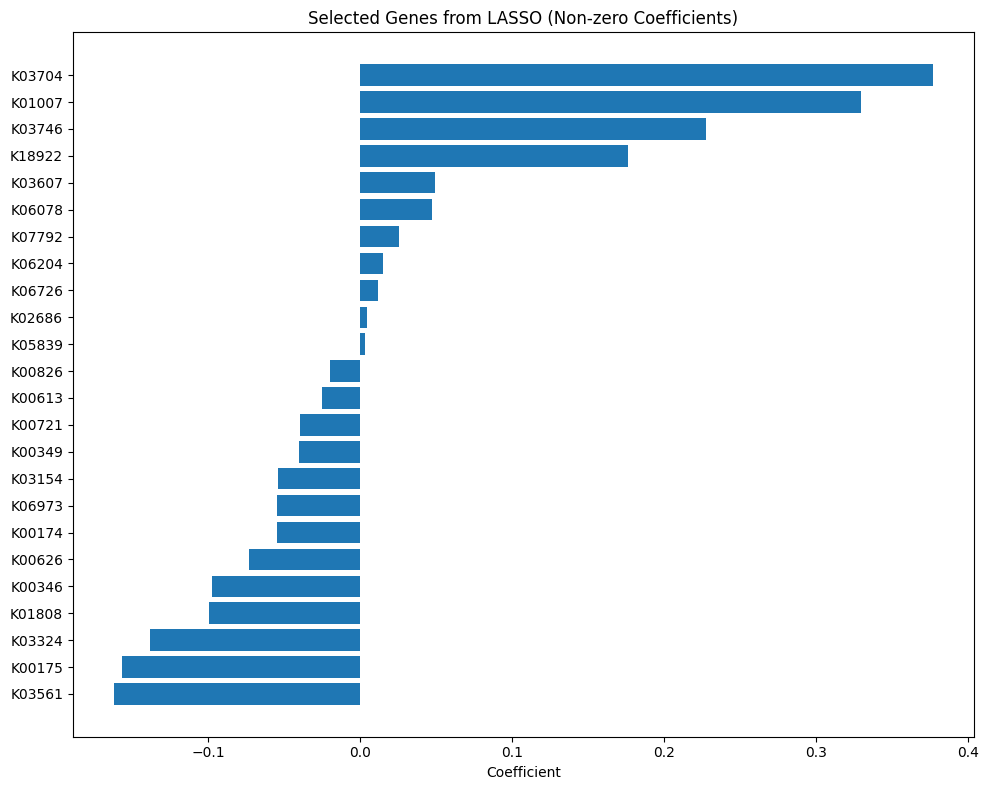

In [59]:
# Extract coefficients and feature names from the final model
coefs_LA = final_model_LA.named_steps['logisticregression'].coef_.flatten()
feature_names = log_X4.columns

# Create a DataFrame of non-zero coefficients
selected = pd.DataFrame({
    'Gene': feature_names,
    'Coefficient': coefs_LA
})
#selected = selected[abs(selected['Coefficient'] != 0]
selected = selected [abs(selected['Coefficient']) > 1e-6].sort_values(by='Coefficient', ascending=False)
# Plot
plt.figure(figsize=(10, 8))
plt.barh(selected['Gene'], selected['Coefficient'])
plt.xlabel("Coefficient")
plt.title("Selected Genes from LASSO (Non-zero Coefficients)")
plt.gca().invert_yaxis()  # Highest coefficient on top
plt.tight_layout()
plt.savefig('meta_lasso_coefficients.png')
plt.show()

In [93]:
selected.shape

(24, 2)

## Elastic Net with LPOCV

In [61]:
n_patients = 15
y_true_EN = []
y_pred_prob_EN = []
selected_genes_list_EN = []

for i in range(n_patients):
    # Leave out both time points for the same patient
    test_idx = [i, i + n_patients]
    train_idx = [j for j in range(2 * n_patients) if j not in test_idx]

    # Split data
    X_train, X_test = log_X4.iloc[train_idx], log_X4.iloc[test_idx]
    y_train, y_test = y_4.iloc[train_idx], y_4.iloc[test_idx]


    # Inner loop for lambda selection
    inner_model_EN = LogisticRegressionCV(
        Cs=10,                      # Number of inverse lambdas to try
        cv=5,
        penalty='elasticnet',
        solver='saga',
        l1_ratios=[0.5],            
        scoring='accuracy',
        max_iter=10000,
        n_jobs=-1
    )

    pipeline_EN = make_pipeline(StandardScaler(), inner_model_EN)
    pipeline_EN.fit(X_train, y_train)


        # Get best parameters
    best_C_EN = inner_model_EN.C_[0]
    best_l1_ratio_EN = inner_model_EN.l1_ratio_[0]

    # Retrain final LA model on full training fold with best parameters
    final_model_EN = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty='elasticnet',
            C=best_C_EN,
            l1_ratio=best_l1_ratio_EN,
            solver='saga',
            max_iter=10000
        )
    )
    final_model_EN.fit(X_train, y_train)

    # Predict on left-out sample
    y_prob_EN = final_model_EN.predict_proba(X_test)[:, 1]
    y_pred_prob_EN.extend(y_prob_EN)
    y_true_EN.extend(y_test.tolist())

    # Get selected features
    coefs_EN = final_model_EN.named_steps['logisticregression'].coef_.flatten()
    selected_genes_EN = log_X4.columns[coefs_EN != 0]
    selected_genes_list_EN.append(selected_genes_EN.tolist())

In [62]:
#Model Evaluation Metrics

y_pred_label_EN = [1 if prob >= 0.5 else 0 for prob in y_pred_prob_EN]
# Accuracy
acc_EN = accuracy_score(y_true_EN, y_pred_label_EN)

# Sensitivity (Recall for class 1)
sensitivity_EN = recall_score(y_true_EN, y_pred_label_EN, pos_label=1)

# Specificity (Recall for class 0)
specificity_EN = recall_score(y_true_EN, y_pred_label_EN, pos_label=0)

# F1 Score
f1_EN = f1_score(y_true_EN, y_pred_label_EN)

# AUC
auc_EN = roc_auc_score(y_true_EN, y_pred_prob_EN)

# Confusion Matrix
cm_EN = confusion_matrix(y_true_EN, y_pred_label_EN)

# Print the results
print(f"Accuracy:    {acc_EN:.3f}")
print(f"Sensitivity: {sensitivity_EN:.3f}")
print(f"Specificity: {specificity_EN:.3f}")
print(f"F1 Score:    {f1_EN:.3f}")
print(f"AUC:         {auc_EN:.3f}")
print("Confusion Matrix:")
print(cm_EN)

Accuracy:    0.867
Sensitivity: 0.867
Specificity: 0.867
F1 Score:    0.867
AUC:         0.880
Confusion Matrix:
[[13  2]
 [ 2 13]]


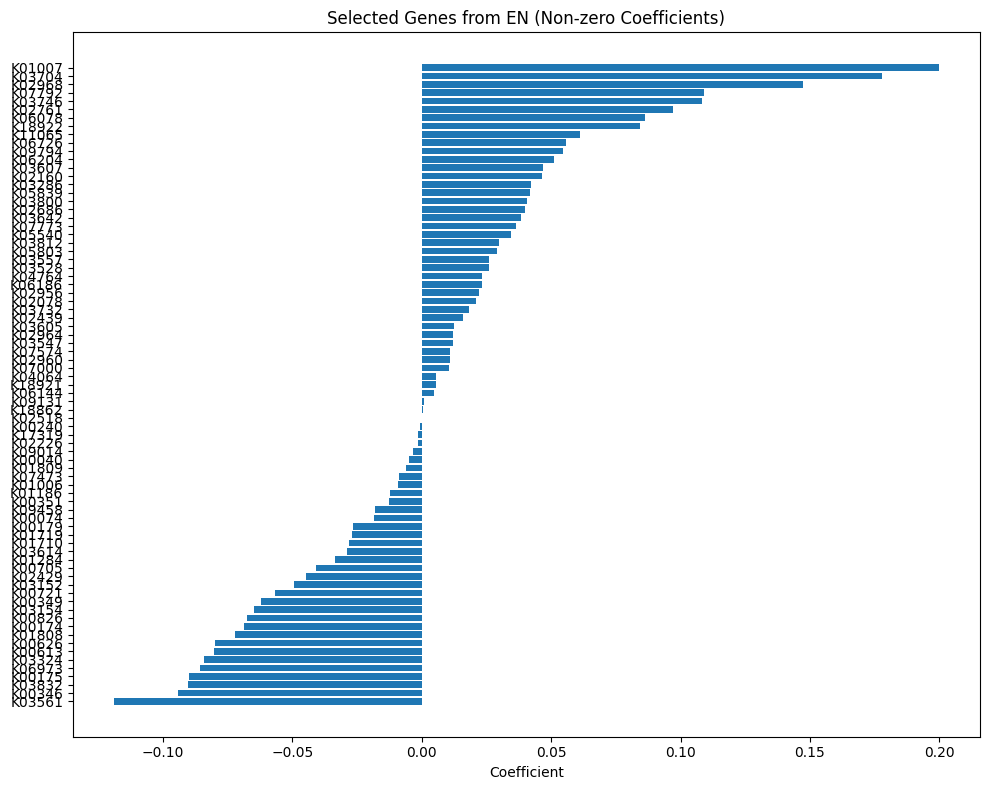

In [67]:
# Extract coefficients and feature names from the final model
coefs_EN = final_model_EN.named_steps['logisticregression'].coef_.flatten()
feature_names = log_X4.columns

# Create a DataFrame of non-zero coefficients
selected_EN = pd.DataFrame({
    'Gene': feature_names,
    'Coefficient': coefs_EN
})
#selected = selected[abs(selected['Coefficient'] != 0]
selected_EN = selected_EN[abs(selected_EN['Coefficient']) > 1e-6].sort_values(by='Coefficient', ascending=False)
# Plot
plt.figure(figsize=(10, 8))
plt.barh(selected_EN['Gene'], selected_EN['Coefficient'])
plt.xlabel("Coefficient")
plt.title("Selected Genes from EN (Non-zero Coefficients)")
plt.gca().invert_yaxis()  # Highest coefficient on top
plt.tight_layout()
plt.savefig('meta_EN_coefficients.png')
plt.show()

In [98]:
selected_EN.shape

(77, 2)

## Brouta + RF (Leave Pair out CV)

In [100]:
# Convert data to NumPy arrays
log_X4 = log_X4.copy()
y_4 = np.array(y_4)

n_patients = 15

# Storage
y_true_all_RF = []
y_pred_all_RF = []
y_prob_all_RF = []
selected_feature_lists = []

for i in range(n_patients):
    test_idx = [i, i + n_patients]
    train_idx = [j for j in range(2 * n_patients) if j not in test_idx]

    X_train, X_test = log_X4.iloc[train_idx], log_X4.iloc[test_idx]
    y_train, y_test = y_4[train_idx], y_4[test_idx]

    # ✅ Scale training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ✅ Feature selection with Boruta
    model_rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )

    boruta = BorutaPy(
        estimator=model_rf,
        n_estimators='auto',
        max_iter=100,
        perc=100,
        verbose=0,
        random_state=42
    )
    boruta.fit(X_train_scaled, y_train)

    selected_idx = boruta.support_
    selected_feature_names = log_X4.columns[selected_idx].tolist()
    selected_feature_lists.append(selected_feature_names)

    X_train_sel = boruta.transform(X_train_scaled)
    X_test_sel = boruta.transform(X_test_scaled)

    # ✅ Final model on selected features
    model_final = RandomForestClassifier(n_estimators=100, random_state=42)
    model_final.fit(X_train_sel, y_train)

    y_pred_RF = model_final.predict(X_test_sel)
    y_prob_RF = model_final.predict_proba(X_test_sel)[:, 1]

    y_true_all_RF.extend(y_test)
    y_pred_all_RF.extend(y_pred_RF)
    y_prob_all_RF.extend(y_prob_RF)


In [101]:
# Final evaluation
acc_RF = accuracy_score(y_true_all_RF, y_pred_all_RF)
f1_RF = f1_score(y_true_all_RF, y_pred_all_RF)
sensitivity_RF = recall_score(y_true_all_RF, y_pred_all_RF, pos_label=1)
specificity_RF = recall_score(y_true_all_RF, y_pred_all_RF, pos_label=0)
auc_RF = roc_auc_score(y_true_all_RF, y_prob_all_RF)
cm_RF = confusion_matrix(y_true_all_RF, y_pred_all_RF)

acc_RF = accuracy_score(y_true_all_RF, y_pred_all_RF)
f1_RF = f1_score(y_true_all_RF, y_pred_all_RF)
sensitivity_RF = recall_score(y_true_all_RF, y_pred_all_RF, pos_label=1)
specificity_RF = recall_score(y_true_all_RF, y_pred_all_RF, pos_label=0)
auc_RF = roc_auc_score(y_true_all_RF, y_prob_all_RF)

print(f"\nAccuracy:    {acc_RF:.3f}")
print(f"F1 Score:    {f1_RF:.3f}")
print(f"Sensitivity: {sensitivity_RF:.3f}")
print(f"Specificity: {specificity_RF:.3f}")
print(f"AUC:         {auc_RF:.3f}")


Accuracy:    0.833
F1 Score:    0.828
Sensitivity: 0.800
Specificity: 0.867
AUC:         0.896


In [102]:
#get the most selected features by brouta across each fold 

all_selected_features = list(chain.from_iterable(selected_feature_lists))

feature_counts = Counter(all_selected_features)

# Sort by most common
most_common_features = feature_counts.most_common()

print("\nMost frequently selected features across folds:")
for feature, count in most_common_features:
    print(f"{feature}: selected in {count} folds")


Most frequently selected features across folds:
K03605: selected in 15 folds
K06726: selected in 15 folds
K01823: selected in 14 folds
K02858: selected in 14 folds
K03303: selected in 14 folds
K09475: selected in 14 folds
K18921: selected in 14 folds
K18922: selected in 14 folds
K00286: selected in 13 folds
K11065: selected in 13 folds
K01438: selected in 9 folds
K03812: selected in 8 folds
K09014: selected in 8 folds
K03286: selected in 8 folds
K01885: selected in 7 folds
K03088: selected in 7 folds
K00648: selected in 4 folds
K14652: selected in 4 folds
K09794: selected in 4 folds
K21572: selected in 4 folds
K00721: selected in 3 folds
K11717: selected in 3 folds
K07479: selected in 3 folds
K00350: selected in 3 folds
K01835: selected in 3 folds
K01866: selected in 3 folds
K02553: selected in 3 folds
K03747: selected in 3 folds
K04032: selected in 3 folds
K05839: selected in 3 folds
K10914: selected in 3 folds
K19168: selected in 3 folds
K22720: selected in 3 folds
K07773: selected 

In [103]:
robust_features = [f for f, count in feature_counts.items() if count >= 12]
print(f"\nFeatures selected in ≥10 folds ({len(robust_features)} total):")
print(robust_features)


Features selected in ≥10 folds (10 total):
['K00286', 'K01823', 'K02858', 'K03303', 'K03605', 'K06726', 'K09475', 'K11065', 'K18921', 'K18922']


/opt/anaconda3/lib/python3.11/site-packages/matplotlib_venn/_util.py:62: UserWarning: venn3_unweighted is deprecated. Use venn3 with the appropriate layout_algorithm instead.
  warnings.warn(


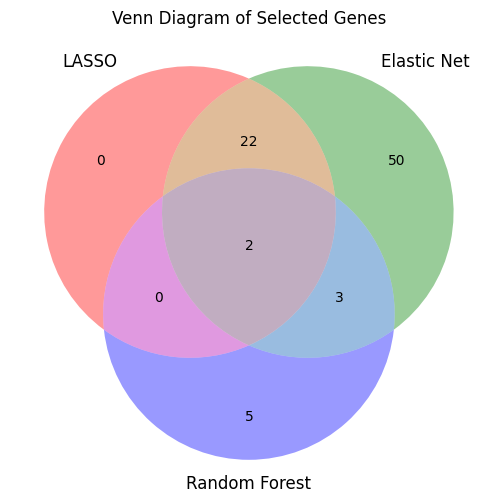

In [104]:
# Define gene sets
lasso_genes = set(selected['Gene'])
enet_genes = set(selected_EN['Gene'])

rf_genes = set(['K00286', 'K01823', 'K02858', 'K03303', 'K03605',
                'K06726', 'K09475', 'K11065', 'K18921', 'K18922'])

# 3. Plot the Venn diagram
plt.figure(figsize=(8, 6))
venn3_unweighted(
    [lasso_genes, enet_genes, rf_genes],
    set_labels=('LASSO', 'Elastic Net', 'Random Forest')
)
plt.title("Venn Diagram of Selected Genes")
plt.savefig("venn_meta.png")
plt.show()

In [105]:
# Find the intersection of all three sets
intersected_genes = lasso_genes & enet_genes & rf_genes

# Show result
print("Intersected genes across LASSO, EN, and RF:")
print(sorted(intersected_genes))

Intersected genes across LASSO, EN, and RF:
['K06726', 'K18922']


In [106]:
# union genes of all models 

union_genes = lasso_genes | enet_genes | rf_genes
print(union_genes)

{'K07773', 'K02956', 'K02429', 'K00351', 'K02226', 'K07473', 'K07000', 'K01710', 'K03800', 'K00179', 'K03746', 'K09458', 'K04064', 'K03154', 'K09131', 'K03704', 'K01186', 'K00349', 'K02960', 'K03528', 'K02968', 'K18922', 'K02439', 'K01719', 'K00705', 'K02078', 'K00174', 'K00346', 'K05839', 'K09014', 'K02160', 'K03547', 'K03812', 'K06144', 'K00721', 'K03303', 'K06078', 'K03152', 'K00040', 'K00613', 'K03607', 'K03732', 'K03832', 'K03605', 'K01823', 'K06186', 'K01284', 'K02686', 'K03614', 'K01006', 'K00286', 'K11065', 'K06204', 'K06726', 'K07792', 'K01007', 'K07574', 'K02518', 'K00240', 'K00074', 'K04764', 'K18921', 'K00826', 'K05803', 'K03324', 'K01809', 'K03286', 'K05540', 'K01808', 'K03557', 'K09475', 'K03642', 'K06973', 'K00175', 'K02858', 'K09794', 'K03561', 'K00626', 'K02761', 'K17319', 'K02964', 'K18862'}


In [107]:
len (union_genes)

82

In [108]:
with open("union_metatranscriptomics.txt", "w") as f:
    for gene in union_genes:
        f.write(f"{gene}\n")

## ROC Curve for all models 

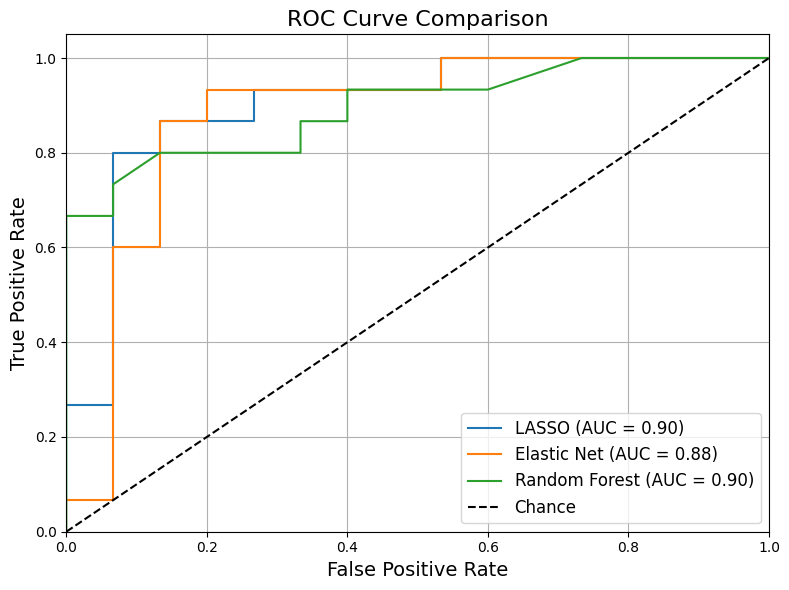

In [110]:
# Compute ROC curve and AUC for each model
fpr_lasso, tpr_lasso, _ = roc_curve(y_true_LA, y_pred_prob_LA)
roc_auc_lasso = auc(fpr_lasso, tpr_lasso)

fpr_en, tpr_en, _ = roc_curve(y_true_EN, y_pred_prob_EN)
roc_auc_en = auc(fpr_en, tpr_en)

fpr_rf, tpr_rf, _ = roc_curve(y_true_all_RF, y_prob_all_RF)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_lasso, tpr_lasso, label=f'LASSO (AUC = {roc_auc_lasso:.2f})')
plt.plot(fpr_en, tpr_en, label=f'Elastic Net (AUC = {roc_auc_en:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

# Axis and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve Comparison', fontsize=16)
plt.legend(loc='lower right', prop={'size': 12})  # legend font size
plt.grid(True)
plt.tight_layout()
plt.savefig("ROC_meta.png")
plt.show()

## ROC Curve for all models  with 95% CI

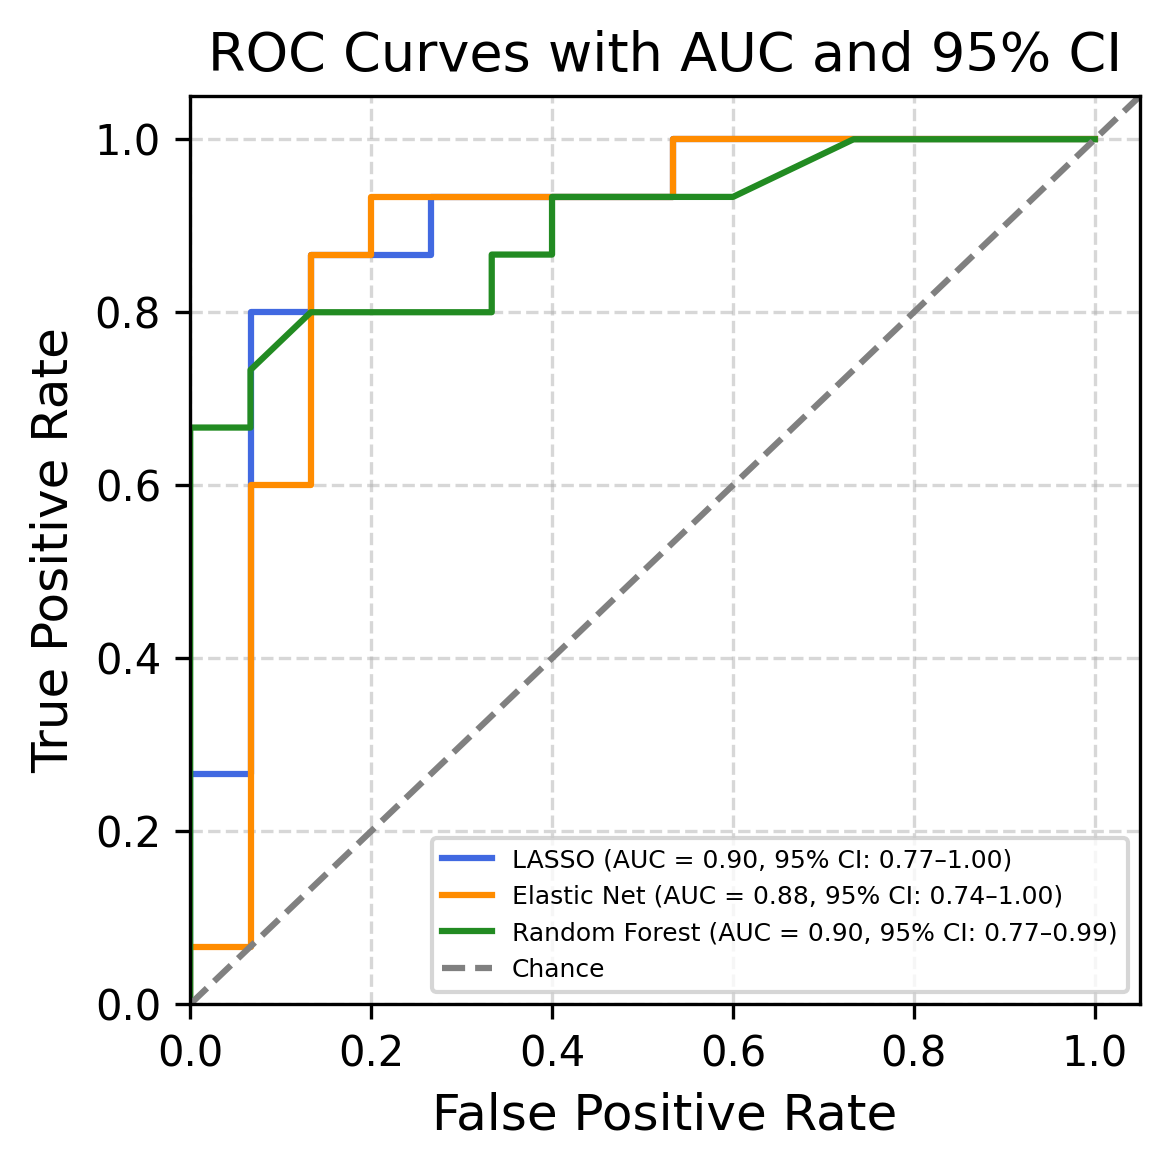

In [112]:

def bootstrap_auc_ci(y_true, y_score, n_bootstraps=1000, seed=42):
    rng = np.random.RandomState(seed)
    aucs = []

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue
        auc = roc_auc_score(y_true[indices], y_score[indices])
        aucs.append(auc)

    aucs = np.array(aucs)
    lower = np.percentile(aucs, 2.5)
    upper = np.percentile(aucs, 97.5)
    mean_auc = roc_auc_score(y_true, y_score)

    return mean_auc, lower, upper

# === Get true ROC + CI for all models ===
# LASSO
fpr_lasso, tpr_lasso, _ = roc_curve(y_true_LA, y_pred_prob_LA)
auc_lasso, ci_lower_lasso, ci_upper_lasso = bootstrap_auc_ci(y_true_LA, y_pred_prob_LA)

# EN
fpr_en, tpr_en, _ = roc_curve(y_true_EN, y_pred_prob_EN)
auc_en, ci_lower_en, ci_upper_en = bootstrap_auc_ci(y_true_EN, y_pred_prob_EN)

# RF
fpr_rf, tpr_rf, _ = roc_curve(y_true_all_RF, y_prob_all_RF)
auc_rf, ci_lower_rf, ci_upper_rf = bootstrap_auc_ci(y_true_all_RF, y_prob_all_RF)

# === Plot setup ===
plt.figure(figsize=(4, 4), dpi=300)

# Plot true ROC curves only
plt.plot(fpr_lasso, tpr_lasso, color='royalblue', linewidth=1.5,
         label=f'LASSO (AUC = {auc_lasso:.2f}, 95% CI: {ci_lower_lasso:.2f}–{ci_upper_lasso:.2f})')
plt.plot(fpr_en, tpr_en, color='darkorange', linewidth=1.5,
         label=f'Elastic Net (AUC = {auc_en:.2f}, 95% CI: {ci_lower_en:.2f}–{ci_upper_en:.2f})')
plt.plot(fpr_rf, tpr_rf, color='forestgreen', linewidth=1.5,
         label=f'Random Forest (AUC = {auc_rf:.2f}, 95% CI: {ci_lower_rf:.2f}–{ci_upper_rf:.2f})')

# Chance line
plt.plot([0, 1.05], [0, 1.05], linestyle='--', color='gray', label='Chance')

# Style
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves with AUC and 95% CI', fontsize=13)
plt.legend(loc='lower right', fontsize=6, frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("ROC_meta_with_CI_legend_only.png", dpi=300)
plt.show()

## Exporting docs 

In [114]:
# baseline vs week 4

# Export to CSV
filtered_b4.to_csv('filtered_b4.csv', index=False)

## Further analysis 

In [116]:
# Compare the 2 KOs interesected from all genes and compare between baseline vs week 4

# Define metadata columns to exclude from log transformation
metadata_cols_4 = ['Timepoint', 'Sample_ID','Patient']  

# Identify expression columns automatically
expr_cols_4 = [col for col in filtered_b4.columns if col not in metadata_cols_4]

# Apply log1p to expression columns only
filtered_4_log = filtered_b4.copy()
filtered_4_log[expr_cols_4] = np.log1p(filtered_b4[expr_cols_4])

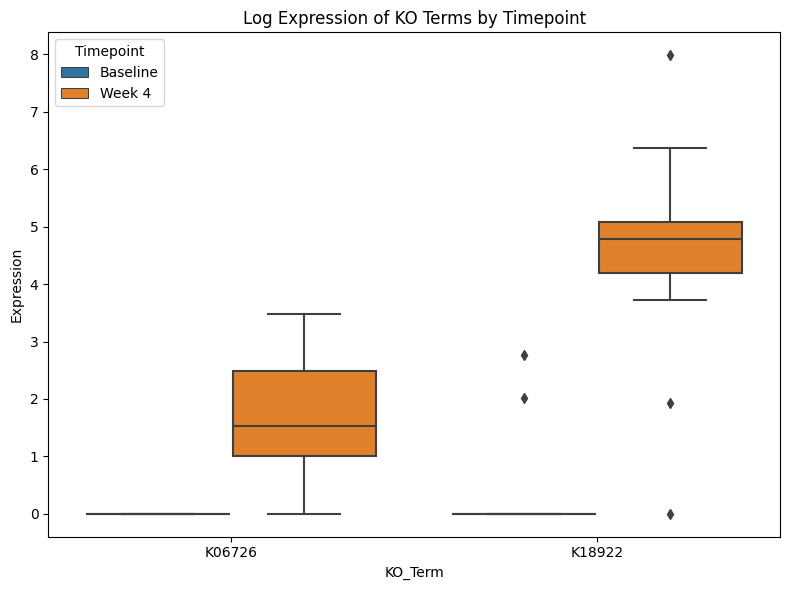

In [117]:
# Box blot 

import pandas as pd

# Melt only for selected KO terms
ko_of_interest = ['K06726', 'K18922']
df_melted_4 = filtered_4_log.melt(id_vars='Timepoint', 
                                value_vars=ko_of_interest, 
                                var_name='KO_Term', 
                                value_name='Expression')

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_melted_4, x='KO_Term', y='Expression', hue='Timepoint')
plt.title('Log Expression of KO Terms by Timepoint')
plt.tight_layout()
plt.show()

In [118]:
# Wilxoxon Test 

from scipy.stats import wilcoxon

for ko in ko_of_interest:
    baseline = filtered_4_log[filtered_4_log['Timepoint'] == 0][ko]
    week4 = filtered_4_log[filtered_4_log['Timepoint'] == 1][ko]
    stat, p = wilcoxon(baseline.values, week4.values)
    print(f"{ko}: Wilcoxon p-value = {p:.4f}")


K06726: Wilcoxon p-value = nan
K18922: Wilcoxon p-value = nan


In [119]:
filtered_b4

,Sample_ID,Patient,Timepoint,K00003,K00005,K00009,K00010,K00012,K00013,K00014,...,K22293,K22373,K22431,K22432,K22454,K22456,K22719,K22720,K22900,K22927
0,1A,1,Baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2A,2,Baseline,0.000000,2.798770,0.000000,0.000000,23.941400,0.000000,33.814800,...,0.000000,1.27729,3.23046,5.282250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3A,3,Baseline,0.000000,0.996578,0.000000,0.000000,18.730700,3.735150,107.213000,...,0.790109,37.65820,2.23452,2.562870,0.440444,2.029500,0.000000,2.601520,0.000000,2.817310
3,4A,4,Baseline,0.000000,6.075270,0.000000,0.000000,1.226320,0.000000,5.685480,...,0.000000,3.79893,0.00000,0.000000,2.991020,4.896100,0.000000,0.000000,0.000000,0.000000
4,5A,5,Baseline,0.000000,0.000000,0.000000,0.000000,14.500800,0.000000,45.093100,...,0.000000,29.50640,0.00000,2.656070,2.686890,5.138600,0.000000,0.000000,0.000000,0.000000
5,6A,6,Baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,7A,7,Baseline,0.000000,1.576310,0.000000,1.037020,3.177790,2.784120,12.339200,...,1.459040,10.06420,0.00000,0.000000,0.398780,0.316875,0.000000,0.104939,0.000000,9.740470
7,8A,8,Baseline,0.000000,6.266730,0.000000,0.000000,7.344350,3.411310,8.530430,...,0.000000,23.16370,3.57893,5.061650,0.000000,1.204240,0.000000,12.193000,0.000000,0.000000
8,9A,9,Baseline,0.000000,22.642200,0.000000,0.000000,0.000000,3.595150,3.167670,...,2.403180,156.41600,0.00000,1.469390,0.000000,0.477195,0.000000,0.000000,1.795960,11.685000
9,10A,10,Baseline,0.000000,0.000000,0.000000,0.000000,4.957760,0.000000,10.983100,...,0.000000,3.12761,0.00000,0.564947,0.000000,0.244412,0.000000,0.000000,0.000000,0.000000


In [120]:

# Metadata columns to exclude from log1p
metadata_cols = ['Sample_ID', 'Patient', 'Timepoint']

# KO expression columns
expr_cols = [col for col in filtered_b4.columns if col not in metadata_cols]

# Apply log1p to KO expression columns
df_log = filtered_b4.copy()
df_log[expr_cols] = np.log1p(filtered_b4[expr_cols])


In [121]:
ko_of_interest = ['K06726', 'K18922']

# Melt the dataframe for plotting
df_melted = df_log.melt(id_vars='Timepoint',
                        value_vars=ko_of_interest,
                        var_name='KO_Term',
                        value_name='Expression')

In [122]:
from scipy.stats import wilcoxon

for ko in ['K06726', 'K18922']:
    baseline = df_log[df_log['Timepoint'] == 'Baseline'][ko]
    week4 = df_log[df_log['Timepoint'] == 'Week 4'][ko]

    # Make sure they are paired — assuming same patient order
    stat, p = wilcoxon(baseline.values, week4.values)
    print(f"{ko} — Wilcoxon p-value: {p:.4f}")


K06726 — Wilcoxon p-value: 0.0010
K18922 — Wilcoxon p-value: 0.0010


/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


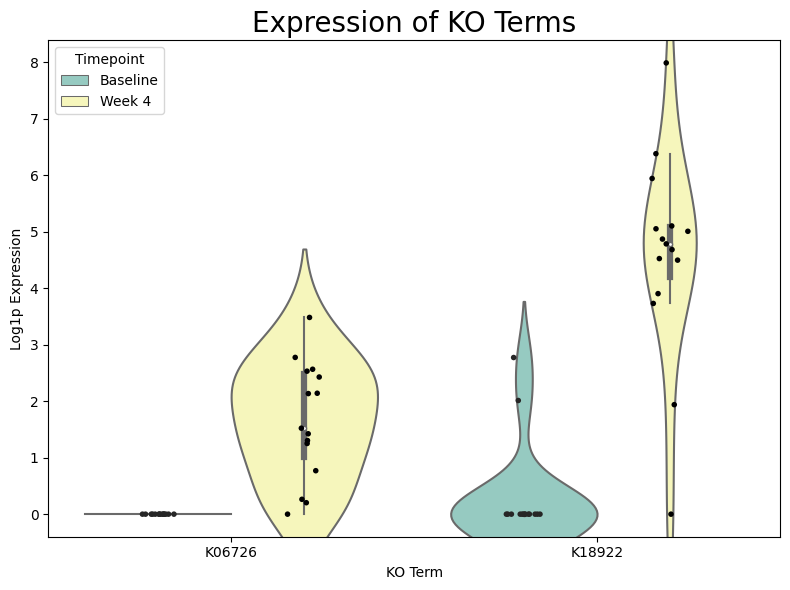

In [123]:

plt.figure(figsize=(8, 6))

# Violin plot
sns.violinplot(
    data=df_melted, x='KO_Term', y='Expression', hue='Timepoint', 
    dodge=True, palette='Set3', alpha=0.8
)

# Strip plot
sns.stripplot(
    data=df_melted, x='KO_Term', y='Expression', hue='Timepoint', 
    dodge=True, color='black', size=4, jitter=True, marker='o'
)

# Fix duplicated legends due to stripplot
handles, labels = plt.gca().get_legend_handles_labels()
n = len(df_melted['Timepoint'].unique())
plt.legend(handles[:n], labels[:n], title='Timepoint')

# Final formatting
plt.title('Expression of KO Terms', fontsize=20)
plt.ylabel('Log1p Expression')
plt.xlabel('KO Term')
plt.tight_layout()
plt.savefig('ko_plot_fixed.png')
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

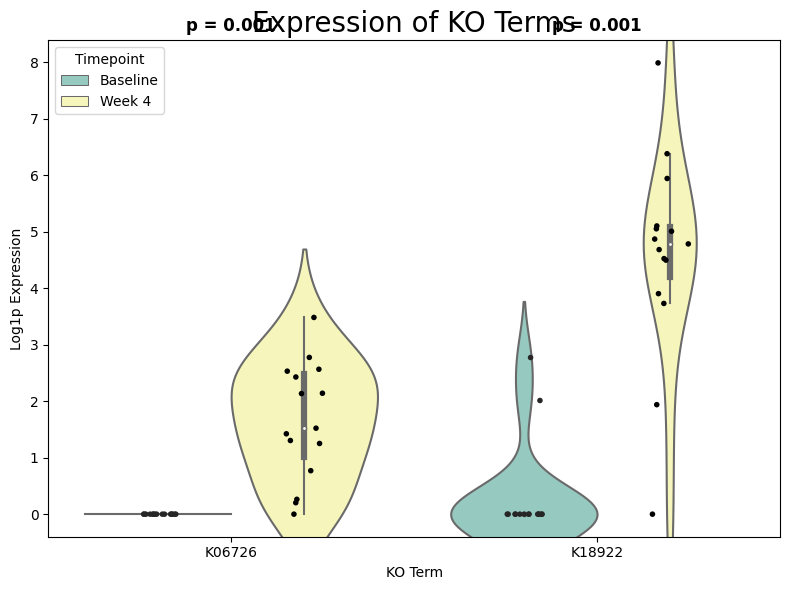

In [124]:
# Step 1: Compute Wilcoxon p-values
p_values = {}
for ko in ['K06726', 'K18922']:
    baseline = df_log[df_log['Timepoint'] == 'Baseline'][ko]
    week4 = df_log[df_log['Timepoint'] == 'Week 4'][ko]
    
    try:
        stat, p = wilcoxon(baseline.values, week4.values)
        p_values[ko] = p
    except:
        p_values[ko] = None  # handle zero variance cases

# Step 2: Melt the data
df_scaled = np.log1p(df_log[['K06726', 'K18922']])  # or use StandardScaler if preferred
df_scaled['Timepoint'] = df_log['Timepoint'].values
#df_melted = df_scaled.melt(id_vars='Timepoint', var_name='KO_Term', value_name='Expression')

# Step 3: Plot
plt.figure(figsize=(8, 6))
ax = sns.violinplot(data=df_melted, x='KO_Term', y='Expression', hue='Timepoint',
                    dodge=True, palette='Set3', alpha=0.8)
sns.stripplot(data=df_melted, x='KO_Term', y='Expression', hue='Timepoint',
              dodge=True, color='black', size=4, jitter=True)

# Step 4: Clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
n = len(df_melted['Timepoint'].unique())
plt.legend(handles[:n], labels[:n], title='Timepoint')

# Step 5: Annotate p-values above violins
for i, ko in enumerate(['K06726', 'K18922']):
    pval = p_values.get(ko)
    if pval is not None:
        plt.text(i, df_melted['Expression'].max() + 0.5, f"p = {pval:.3f}",
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

# Final touches
plt.title('Expression of KO Terms', fontsize=20)
plt.ylabel('Log1p Expression')
plt.xlabel('KO Term')
plt.tight_layout()
plt.savefig('meta_violin_plot.png')
plt.show()

In [125]:
search_terms_u_t = ['Sample_ID', 'K00613', 'K04764', 'K03547', 'K03832', 'K01284',
                  'K03561', 'K00626', 'K07773', 'K03605', 'K00240',
                  'K00705', 'K01808', 'K02160', 'K18921', 'K09794',
                  'K01186', 'K03286', 'K00074', 'K06186', 'K03528',
                  'K07000', 'K06973', 'K07473', 'K06078', 'K00179',
                  'K00826', 'K03746', 'K06144', 'K09475', 'K02956', 'K05540', 'K03614', 'K03154', 'K03303', 'K00175',
                  'K02439', 'K02964', 'K03642', 'K02226', 'K03324', 'K02518', 'K00346', 'K09131', 'K03812', 'K00174',
                  'K03607', 'K00349', 'K07792', 'K18862', 'K01710', 'K01809', 'K01006', 'K05803', 'K02686', 'K03732',
                  'K18922', 'K07574', 'K04064', 'K06726', 'K01007', 'K02968', 'K00040', 'K03152', 'K09458', 'K02960',
                  'K09014', 'K06204', 'K00721', 'K05839', 'K03800', 'K02858', 'K03704', 'K01719', 'K00286', 'K01823',
                  'K02761', 'K02078', 'K17319', 'K00351', 'K02429', 'K11065', 'K03557', 'Timepoint',]

filtered_b4_selected = filtered_b4[search_terms_u_t]

In [126]:
# Save the dataframe
filtered_b4_selected.to_csv("Metatranscriptomics_values.csv", index=False)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future 

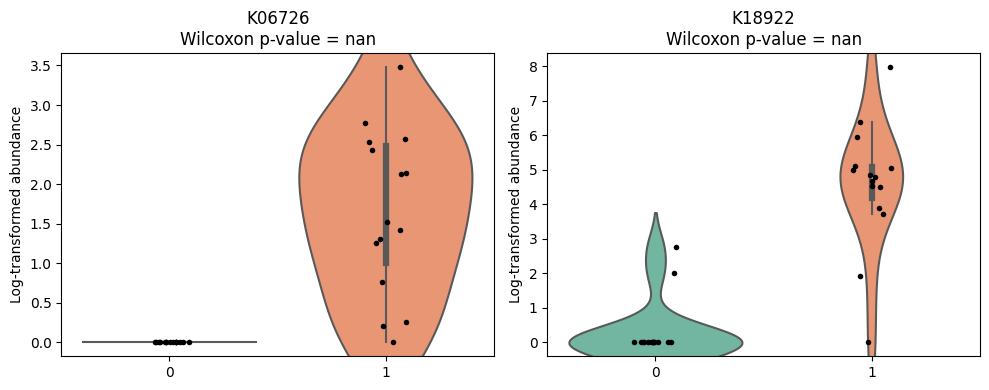

In [127]:
# First create a DataFrame combining features and labels
# Apply log1p to KO expression columns

df_plot = log_X4.copy()
df_plot['Group'] = y_4 

df_log = filtered_b4.copy()
df_log[expr_cols] = np.log1p(filtered_b4[expr_cols])



# Initialize figure
n = len(search_terms)
cols = 2
rows = math.ceil(n / cols)


plt.figure(figsize=(cols * 5, rows * 4))

for i, metabolite in enumerate(search_terms):
    plt.subplot(rows, cols, i+1)
    
    # Extract paired data
    before = df_plot[df_plot['Group'] == 'Baseline'][metabolite].values
    after = df_plot[df_plot['Group'] == 'Week 4'][metabolite].values
    
    # Wilcoxon signed-rank test
    stat, p_value = wilcoxon(before, after)
    
    # Plot
    sns.violinplot(x='Group', y=metabolite, data=df_plot, palette="Set2")
    sns.stripplot(x='Group', y=metabolite, data=df_plot, color='black', size=4, jitter=True)
    plt.title(f"{metabolite}\nWilcoxon p-value = {p_value:.3f}")
    plt.xlabel('')
    plt.ylabel('Log-transformed abundance')

plt.tight_layout()
plt.savefig('violin_plot_meta.png')
plt.show()

## Violing plot for significant features 

In [129]:
# box plot or violin plot with p-values 

selected_meta_all = ['K06726', 'K18922']
X_log_selected = log_X4[selected_meta_all]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future 

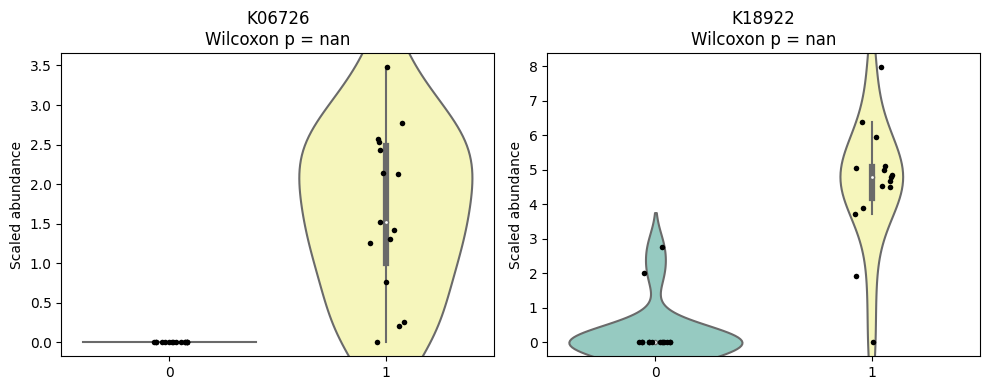

In [130]:
# First create a DataFrame combining features and labels
df_plot = X_log_selected.copy()
df_plot['Group'] = y_4  # add your treatment labels


# Plotting
plt.figure(figsize=(10, 4))

for i, feature in enumerate(selected_meta_all):
    plt.subplot(1, 2, i + 1)
    
    # Extract paired data
    before = df_plot[df_plot['Group'] == 'Baseline'][feature].values
    after = df_plot[df_plot['Group'] == 'Week 4'][feature].values

    # Wilcoxon signed-rank test
    stat, p_value = wilcoxon(before, after)

    # Plot violin + strip plot
    sns.violinplot(x='Group', y=feature, data=df_plot, palette="Set3")
    sns.stripplot(x='Group', y=feature, data=df_plot, color='black', size=4, jitter=True)
    plt.title(f"{feature}\nWilcoxon p = {p_value:.3f}")
    plt.xlabel('')
    plt.ylabel('Scaled abundance')

plt.tight_layout()
plt.savefig('violin_plot_meta.png')
plt.show()